In [1]:
using OrdinaryDiffEq, SteadyStateDiffEq, ModelingToolkit
using Plots

In [2]:
include("../../src/indexing.jl")
include("../../src/doubleSums.jl")
include("../../src/averageSums.jl")
include("../../src/indexedMeanfield.jl")
include("../../src/indexedScale.jl")
include("../../src/indexedCorrelation.jl")

indexed_complete_corr! (generic function with 1 method)

In [3]:
M = 2 # order
@cnumbers N Δ g κ Γ R ν

# Hilbertspace
hc = FockSpace(:cavity)
ha_ = NLevelSpace(:atom,2)
ha = ClusterSpace(ha_, N, M)
h = hc ⊗ ha

ℋ(cavity) ⊗ Nxℋ(atom)

In [4]:
# operators
@qnumbers a::Destroy(h)
σ(i,j) = Transition(h, :σ, i, j, 2)
σ(2,2)

4-element Vector{QSym}:
 σ_122
 σ_222
 σ_322
 σ_422

In [5]:
# Hamiltonian
H = -Δ*a'a + g*(a'*sum(σ(1,2)) + a*sum(σ(2,1)))

# Jump operators & rates
J = [a, σ(1,2), σ(2,1), σ(2,2)]
rates = [κ, Γ, R, ν]

4-element Vector{Sym{Parameter, Base.ImmutableDict{DataType, Any}}}:
 κ
 Γ
 R
 ν

In [6]:
# Derive equations
ops = [a'*a, σ(2,2)[1]]
eqs = meanfield(ops,H,J;rates=rates,order=M)

∂ₜ(⟨a′*a⟩) = (0//1 - 1//1*im)*N*g*⟨a′*σ_112⟩ + (0//1 + 1//1*im)*N*g*⟨a*σ_121⟩ - κ*⟨a′*a⟩
∂ₜ(⟨σ_122⟩) = R + (0 + 1im)*g*⟨a′*σ_112⟩ + (0 - 1im)*g*⟨a*σ_121⟩ - R*⟨σ_122⟩ - Γ*⟨σ_122⟩


In [7]:
# custom filter function
φ(x::Average) = φ(x.arguments[1])
φ(::Destroy) = -1
φ(::Create) =1
φ(x::QTerm) = sum(map(φ, x.args_nc))
φ(x::Transition) = x.i - x.j
phase_invariant(x) = iszero(φ(x))

# Complete equations
eqs_c = complete(eqs; filter_func=phase_invariant)

∂ₜ(⟨a′*a⟩) = (0//1 - 1//1*im)*N*g*⟨a′*σ_112⟩ + (0//1 + 1//1*im)*N*g*⟨a*σ_121⟩ - κ*⟨a′*a⟩
∂ₜ(⟨σ_122⟩) = R + (0 + 1im)*g*⟨a′*σ_112⟩ + (0 - 1im)*g*⟨a*σ_121⟩ - R*⟨σ_122⟩ - Γ*⟨σ_122⟩
∂ₜ(⟨a′*σ_112⟩) = (0 + 1im)*g*⟨σ_122⟩ + (0 - 1im)*g*⟨a′*a⟩ + (0 + 2im)*g*⟨a′*a*σ_122⟩ + (0 - 1im)*Δ*⟨a′*σ_112⟩ + (0 + 3im)*g*((1//3)*N - (1//1))*⟨σ_121*σ_212⟩ - 0.5R*⟨a′*σ_112⟩ - 0.5Γ*⟨a′*σ_112⟩ - 0.5κ*⟨a′*σ_112⟩ - 0.5ν*⟨a′*σ_112⟩
∂ₜ(⟨a′*a*σ_122⟩) = R*⟨a′*a⟩ + (0 + 1im)*g*⟨a′*a′*a*σ_112⟩ + (0 - 1im)*g*⟨a′*a*a*σ_121⟩ + (0 - 3im)*g*((1//3)*N - (1//1))*⟨a′*σ_122*σ_212⟩ + (0 + 3im)*g*((1//3)*N - (1//1))*⟨a*σ_122*σ_221⟩ - R*⟨a′*a*σ_122⟩ - Γ*⟨a′*a*σ_122⟩ - κ*⟨a′*a*σ_122⟩
∂ₜ(⟨σ_121*σ_212⟩) = (0 + 1im)*g*⟨a′*σ_112⟩ + (0 - 1im)*g*⟨a*σ_121⟩ + (0 - 2im)*g*⟨a′*σ_122*σ_212⟩ + (0 + 2im)*g*⟨a*σ_122*σ_221⟩ - R*⟨σ_121*σ_212⟩ - Γ*⟨σ_121*σ_212⟩ - ν*⟨σ_121*σ_212⟩
∂ₜ(⟨a′*a′*a*σ_112⟩) = g*((0 + 2im)*⟨a′*a*σ_122⟩ + (0 + 2im)*⟨σ_122⟩*⟨a′*a′*a*a⟩ + (0 - 8im)*(⟨a′*a⟩^2)*⟨σ_122⟩ + (0 + 8im)*⟨a′*a⟩*⟨a′*a*σ_122⟩) + (0 - 1im)*g*⟨a′*a′*a*a⟩ +

In [8]:
@named sys = ODESystem(eqs_c)

Model sys with 18 equations
States (18):
  var"⟨a′*a⟩"(t)
  var"⟨σ_122⟩"(t)
  var"⟨a′*σ_112⟩"(t)
  var"⟨a′*a*σ_122⟩"(t)
  var"⟨σ_121*σ_212⟩"(t)
  var"⟨a′*a′*a*σ_112⟩"(t)
⋮
Parameters (7):
  g
  κ
  N
  R
  Γ
  Δ
⋮

In [9]:
# Initial state
u0 = zeros(ComplexF64, length(eqs_c))
# System parameters
N_ = 2e5
Γ_ = 1.0 #Γ=1mHz
Δ_ = 2500Γ_ #Δ=2.5Hz
g_ = 1000Γ_ #g=1Hz
κ_ = 5e6*Γ_ #κ=5kHz
R_ = 1000Γ_ #R=1Hz
ν_ = 1000Γ_ #ν=1Hz

ps = [N, Δ, g, κ, Γ, R, ν]
p0 = [N_, Δ_, g_, κ_, Γ_, R_, ν_]

prob = ODEProblem(sys,u0,(0.0, 1.0/50Γ_), ps.=>p0)

ODEProblem with uType Vector{ComplexF64} and tType Float64. In-place: true
timespan: (0.0, 0.02)
u0: 18-element Vector{ComplexF64}:
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [10]:
sol = solve(prob,Tsit5(),maxiters=1e7)

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\julia\.julia\packages\SciMLBase\BoNUy\src\integrator_interface.jl:345


retcode: DtLessThanMin
Interpolation: specialized 4th order "free" interpolation
t: 6916-element Vector{Float64}:
 0.0
 6.720464883946441e-7
 9.774803634135418e-7
 1.5333012449827446e-6
 2.0624649588283503e-6
 2.6073970971751204e-6
 2.9424187701921686e-6
 3.259545742502369e-6
 3.5889960390575563e-6
 3.9372965864423186e-6
 4.3018740185787385e-6
 4.674680185448769e-6
 5.047640491353612e-6
 ⋮
 0.0024115656752075653
 0.0024115656752120625
 0.00241156567521541
 0.0024115656752179016
 0.002411565675219756
 0.0024115656752211364
 0.002411565675222164
 0.0024115656752229284
 0.0024115656752234974
 0.002411565675223921
 0.0024115656752242364
 0.002411565675224471
u: 6916-element Vector{Vector{ComplexF64}}:
 [0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [2.516780063491424e-6 + 0.0im, 0.0006718204214535034 + 0

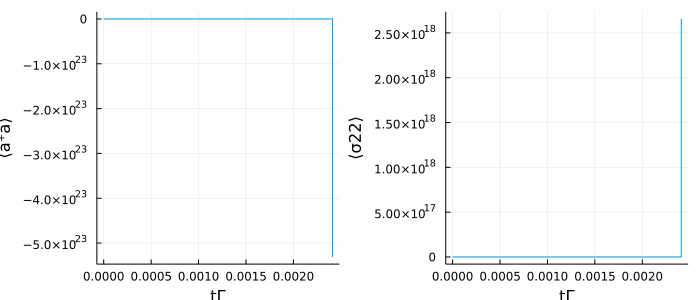

In [11]:
# Plot time evolution
t = sol.t
n = real.(sol[a'a])
s22 = real.(sol[σ(2,2)[1]])

# Plot
p1 = plot(t, n, xlabel="tΓ", ylabel="⟨a⁺a⟩", legend=false)
p2 = plot(t, s22, xlabel="tΓ", ylabel="⟨σ22⟩", legend=false)
plot(p1, p2, layout=(1,2), size=(700,300))

In [12]:
corr = CorrelationFunction(a', a, eqs_c; steady_state=true, filter_func=phase_invariant)
S = Spectrum(corr, ps)

ℱ(⟨a′*a_0⟩)(ω)

In [13]:
corr.de

∂ₜ(⟨a′*a_0⟩) = (0 - 1im)*Δ*⟨a′*a_0⟩ + (0//1 + 1//1*im)*N*g*⟨σ_121*a_0⟩ - 0.5κ*⟨a′*a_0⟩
∂ₜ(⟨σ_121*a_0⟩) = (0 + 1im)*g*⟨a′*a_0⟩ + (0 - 2im)*g*⟨a′*σ_122*a_0⟩ - 0.5R*⟨σ_121*a_0⟩ - 0.5Γ*⟨σ_121*a_0⟩ - 0.5ν*⟨σ_121*a_0⟩
∂ₜ(⟨a′*σ_122*a_0⟩) = R*⟨a′*a_0⟩ + (0 - 1im)*Δ*⟨a′*σ_122*a_0⟩ + (0 + 1im)*g*⟨a′*a′*σ_112*a_0⟩ + (0 - 1im)*g*⟨a′*a*σ_121*a_0⟩ + (0 + 3im)*g*((1//3)*N - (1//1))*⟨σ_122*σ_221*a_0⟩ - R*⟨a′*σ_122*a_0⟩ - Γ*⟨a′*σ_122*a_0⟩ - 0.5κ*⟨a′*σ_122*a_0⟩
∂ₜ(⟨a′*a′*σ_112*a_0⟩) = g*((0 + 2im)*⟨a′*σ_122*a_0⟩ + (0 + 2im)*⟨σ_122⟩*⟨a′*a′*a*a_0⟩ + (0 + 4im)*⟨a′*a⟩*⟨a′*σ_122*a_0⟩ + (0 + 4im)*⟨a′*a_0⟩*⟨a′*a*σ_122⟩ + (0 - 8im)*⟨σ_122⟩*⟨a′*a⟩*⟨a′*a_0⟩) + (0 - 1im)*g*⟨a′*a′*a*a_0⟩ + (0 - 2im)*Δ*⟨a′*a′*σ_112*a_0⟩ + (0 + 6im)*g*((1//3)*N - (1//1))*⟨a′*σ_121*σ_212*a_0⟩ - 0.5R*⟨a′*a′*σ_112*a_0⟩ - 0.5Γ*⟨a′*a′*σ_112*a_0⟩ - κ*⟨a′*a′*σ_112*a_0⟩ - 0.5ν*⟨a′*a′*σ_112*a_0⟩
∂ₜ(⟨a′*a*σ_121*a_0⟩) = (0 - 1im)*g*⟨a′*σ_122*a_0⟩ + (0 + 1im)*g*⟨a′*a′*a*a_0⟩ + (0 - 2im)*g*(⟨σ_122⟩*⟨a′*a′*a*a_0⟩ + 2⟨a′*a⟩*⟨a′*σ_122*a_0⟩ + 2⟨a′*a_

In [14]:
prob_ss = SteadyStateProblem(prob)
sol_ss = solve(prob_ss, DynamicSS(Tsit5(); abstol=1e-8, reltol=1e-8),
    reltol=1e-14, abstol=1e-14, maxiters=5e7)

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\julia\.julia\packages\SciMLBase\BoNUy\src\integrator_interface.jl:345


u: 18-element Vector{ComplexF64}:
 -3.8337768305337964e18 + 0.0im
   1.916890848911449e13 + 0.0im
  -2.396112039794764e13 - 7.547732765603757e22im
 -2.9651417615485937e32 + 0.0im
 -1.4927474220086914e27 + 0.0im
   3.681037539944267e32 + 1.1595258204439387e42im
 -1.8532392480303374e27 - 5.877673504187115e36im
   5.889666957386185e37 + 0.0im
 -2.2883537261460764e46 + 1.449424705770975e37im
   2.288353726146077e46 - 9.142653753820419e18im
  1.4927474220085859e27 + 0.0im
 -2.3178184907862564e46 + 9.142653753820419e18im
 -1.1796567372367586e41 - 5.484062709354556e-23im
  1.4302357101190325e41 + 4.528864708040097e50im
 -1.4486513745133348e41 - 4.702892174188847e50im
   8.989905478415983e54 - 1.8153144579988593e28im
  1.1943892706230016e41 + 0.0im
  -9.530440929869472e54 + 3.5128501021986574e28im

In [15]:
ω = [-10:0.01:10;]Γ_
spec = S(ω,sol_ss.u,p0)
spec_n = spec ./ maximum(spec)
δ = abs(ω[(findmax(spec)[2])])

4.94

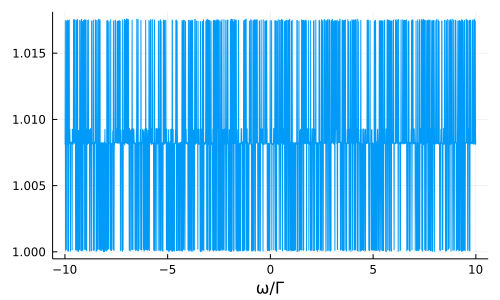

In [16]:
plot(ω, spec_n, xlabel="ω/Γ", legend=false, size=(500,300))